In [16]:
import json
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

# Load JSON file
with open("simplified_data_ashwagandha.json", "r", encoding="utf-8") as f:
    data = json.load(f)

studies = data


In [30]:
records = []

for t in studies:
    nct_id = t.get("nctId")
    start_date = t.get("start_date")
    ingredients = t.get("generic_ingredients", [])

    if not start_date:
        continue

    for ing in ingredients:
        records.append({
            "nctId": nct_id,
            "ingredient": ing,
            "start_date": start_date,
        })

df = pd.DataFrame(records)

INGREDIENTS TOP 5 PER YEAR

C:\Users\perma\AppData\Local\Temp\ipykernel_211260\1040777760.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = df["start_date"].dt.year


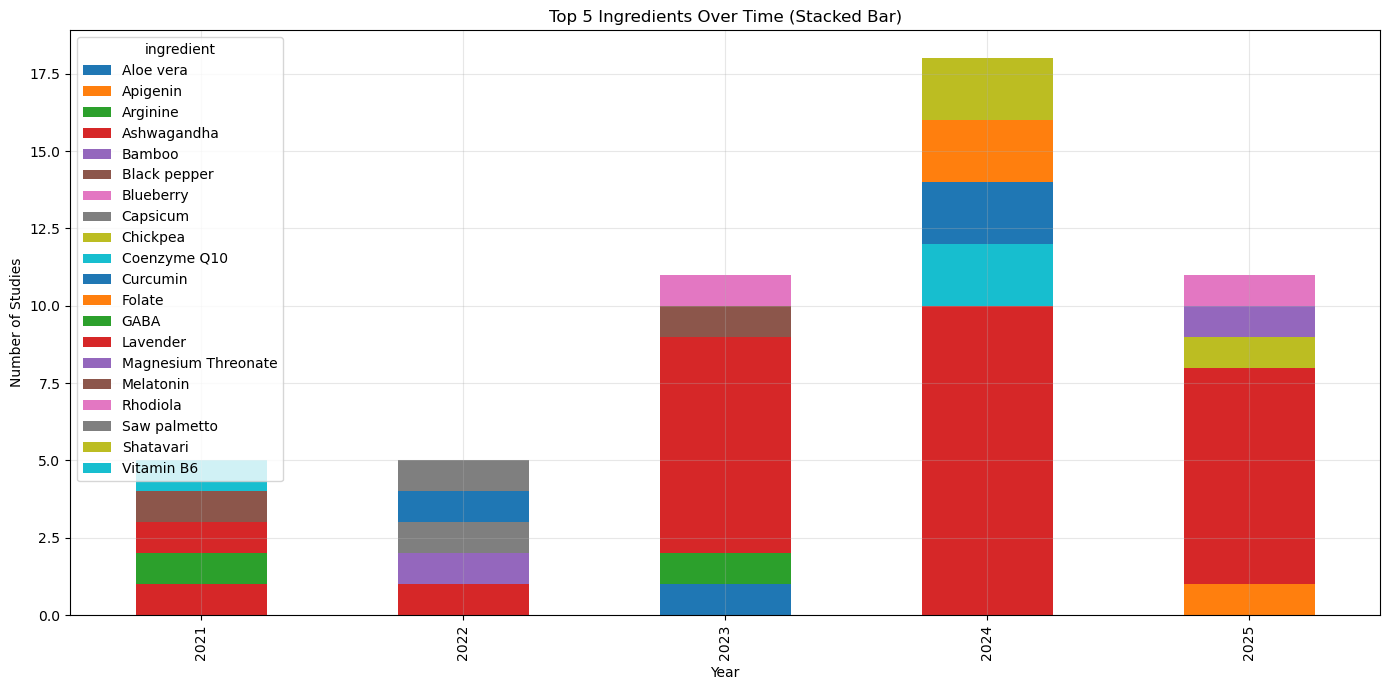

In [18]:
df["start_date"] = pd.to_datetime(df["start_date"], errors="coerce")
df = df.dropna(subset=["start_date"])
df["year"] = df["start_date"].dt.year

# Count combinations of year + ingredient
counts = (
    df.groupby(["year", "ingredient"])
      .size()
      .reset_index(name="count")
)

# Sort within each year and take top 5
top5_per_year = (
    counts
    .sort_values(["year", "count"], ascending=[True, False])
    .groupby("year")
    .head(5)
)

# Filter original dataframe to only these top 5 ingredients per year
df_top5 = df.merge(
    top5_per_year[["year", "ingredient"]],
    on=["year", "ingredient"]
)

pivot = (
    df_top5.groupby(["year", "ingredient"])
           .size()
           .unstack(fill_value=0)
           .sort_index()
)


pivot.plot(kind="bar", stacked=True, figsize=(14, 7))

plt.title("Top 5 Ingredients Over Time (Stacked Bar)")
plt.xlabel("Year")
plt.ylabel("Number of Studies")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

CATEGORIES TOP 5 PER YEAR

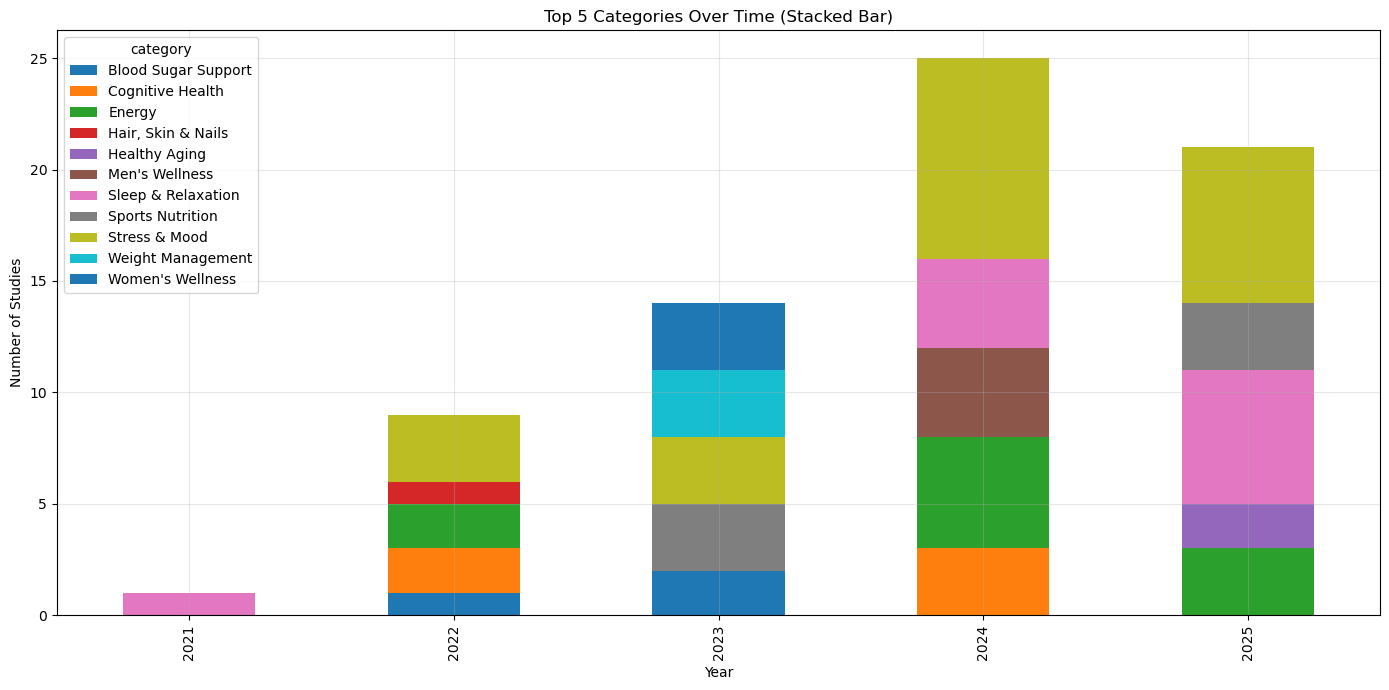

In [19]:
# ---- Categories: build separate records ----
cat_records = []

for t in studies:
    nct_id = t.get("nctId")
    start_date = t.get("start_date")
    categories = t.get("categories", [])  # <-- categories array per study

    if not start_date:
        continue

    for cat in categories:
        cat_records.append({
            "nctId": nct_id,
            "category": cat,
            "start_date": start_date,
        })

df_cat = pd.DataFrame(cat_records)

df_cat["start_date"] = pd.to_datetime(df_cat["start_date"], errors="coerce")
df_cat = df_cat.dropna(subset=["start_date"])
df_cat["year"] = df_cat["start_date"].dt.year

# Count combinations of year + category
cat_counts = (
    df_cat.groupby(["year", "category"])
          .size()
          .reset_index(name="count")
)

# Sort within each year and take top 5 categories
top5_cat_per_year = (
    cat_counts
    .sort_values(["year", "count"], ascending=[True, False])
    .groupby("year")
    .head(5)
)

# Filter to only top 5 categories per year
df_top5_cat = df_cat.merge(
    top5_cat_per_year[["year", "category"]],
    on=["year", "category"]
)

pivot_cat = (
    df_top5_cat.groupby(["year", "category"])
               .size()
               .unstack(fill_value=0)
               .sort_index()
)

pivot_cat.plot(kind="bar", stacked=True, figsize=(14, 7))

plt.title("Top 5 Categories Over Time (Stacked Bar)")
plt.xlabel("Year")
plt.ylabel("Number of Studies")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


CO OCCURENCE 

In [20]:
pair_records = []

for t in studies:
    start_date = t.get("start_date")
    ingredients = t.get("generic_ingredients", [])

    if not start_date or len(ingredients) < 2:
        continue

    # Generate pairs like ("Curcumin", "Black Pepper")
    ingredient_pairs = list(combinations(sorted(set(ingredients)), 2))

    for a, b in ingredient_pairs:
        pair_records.append({
            "pair_a": a,
            "pair_b": b,
            "start_date": start_date
        })

df_pairs = pd.DataFrame(pair_records)

df_pairs["start_date"] = pd.to_datetime(df_pairs["start_date"], errors="coerce")
df_pairs = df_pairs.dropna(subset=["start_date"])
df_pairs["year"] = df_pairs["start_date"].dt.year

global_pairs = (
    df_pairs.groupby(["pair_a", "pair_b"])
            .size()
            .reset_index(name="count")
            .sort_values("count", ascending=False)
)

print(global_pairs.head(20))


           pair_a                pair_b  count
106   Ashwagandha                  Zinc      3
68    Ashwagandha              Curcumin      3
101   Ashwagandha            Vitamin B6      3
81    Ashwagandha             Melatonin      2
57    Ashwagandha          Black pepper      2
92    Ashwagandha          Saw palmetto      2
70    Ashwagandha                Folate      2
168  Black pepper                  Zinc      2
94    Ashwagandha             Shatavari      2
63    Ashwagandha              Chickpea      2
65    Ashwagandha          Coenzyme Q10      2
213  Coenzyme Q10              Curcumin      2
278        Folate            Vitamin B6      2
280        Folate                  Zinc      2
391    Vitamin B6                  Zinc      2
4           Algae              Curcumin      1
5           Algae  Marine Phytoplankton      1
6           Algae             Melatonin      1
7           Algae          Milk thistle      1
8       Aloe vera              Arginine      1


AVERAGE GROWTH RATE

In [29]:
# ASSUMES: df has columns ["nctId", "ingredient", "year"]

# 1) DISTINCT: one ingredient per study per year
ingredient_year_counts = (
    df.drop_duplicates(subset=["nctId", "ingredient", "year"])
      .groupby(["ingredient", "year"])
      .size()
      .reset_index(name="count")
)

# 2) Sort by ingredient then by year
ingredient_year_counts = ingredient_year_counts.sort_values(["ingredient", "year"])

# 3) previous year's count per ingredient
ingredient_year_counts["prev_count"] = (
    ingredient_year_counts
    .groupby("ingredient")["count"]
    .shift(1)
)

# 4) compute YoY growth rate
ingredient_year_counts["growth_yoy"] = (
    (ingredient_year_counts["count"] - ingredient_year_counts["prev_count"])
    / ingredient_year_counts["prev_count"]
)

# 5) avoid division by zero or NaN prev_count
ingredient_year_counts.loc[
    (ingredient_year_counts["prev_count"].isna()) |
    (ingredient_year_counts["prev_count"] == 0),
    "growth_yoy"
] = np.nan

# 6) keep only valid growth rows
valid_growth = ingredient_year_counts.dropna(subset=["growth_yoy"]).copy()

# 7) average growth per ingredient (distinct ingredients overall)
avg_growth = (
    valid_growth
    .groupby("ingredient")["growth_yoy"]
    .mean()
    .reset_index(name="avg_growth_yoy")
)

# 8) percentage form and sort
avg_growth["avg_growth_yoy_pct"] = avg_growth["avg_growth_yoy"] * 100
avg_growth_sorted = avg_growth.sort_values("avg_growth_yoy_pct", ascending=False)

avg_growth_sorted

,ingredient,avg_growth_yoy,avg_growth_yoy_pct
0,Ashwagandha,1.532143,153.214286
7,Zinc,1.000000,100.000000
6,Vitamin B6,1.000000,100.000000
3,Curcumin,0.500000,50.000000
2,Chickpea,0.000000,0.000000
1,Black pepper,0.000000,0.000000
5,Saw palmetto,0.000000,0.000000
4,Melatonin,0.000000,0.000000


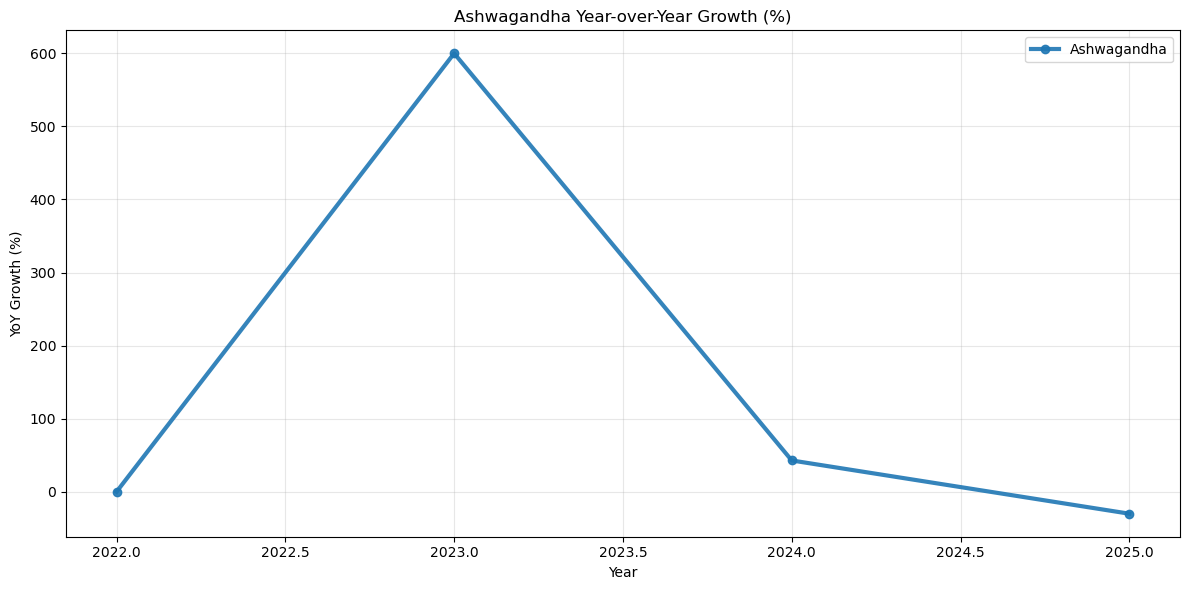

In [26]:
# --- set your ingredient target here ---
target_ingredient = "Ashwagandha"   # ← The query of API was for ashwagandha change it here if needed

# --- Compute YoY Growth Pivot ---
growth_pivot = (
    ingredient_year_counts
        .pivot(index="year", columns="ingredient", values="growth_yoy_pct")
        .sort_index()
)

# --- Validate ingredient exists ---
if target_ingredient not in growth_pivot.columns:
    raise ValueError(f"{target_ingredient} not found in ingredient list.")

# --- Extract growth series ---
ingredient_growth = growth_pivot[target_ingredient]

# --- Plot ---
plt.figure(figsize=(12, 6))

plt.plot(
    ingredient_growth.index,
    ingredient_growth.values,
    marker="o",
    linewidth=3,
    alpha=0.9,
    label=target_ingredient
)

plt.title(f"{target_ingredient} Year-over-Year Growth (%)")
plt.xlabel("Year")
plt.ylabel("YoY Growth (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()